In [1]:
!pip install timm==0.6.5
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.8/512.8 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12


In [2]:
import math
from functools import partial

from einops import rearrange, reduce, repeat
# from mmcv.ops import DeformConv2d
from torchvision.ops import DeformConv2d
import torch.nn.functional as F
from timm.models.layers.activations import *
from timm.models.layers import DropPath, trunc_normal_

init_alpha_value = 1e-3
init_scale_values = 1e-4


# ========== For Common ==========
class LayerNormConv(nn.Module):
	
	def __init__(self, normalized_shape, eps=1e-6, elementwise_affine=True):
		super().__init__()
		self.norm = nn.LayerNorm(normalized_shape, eps, elementwise_affine)
	
	def forward(self, x):
		x = rearrange(x, 'b c h w -> b h w c').contiguous()
		x = self.norm(x)
		x = rearrange(x, 'b h w c -> b c h w').contiguous()
		return x


def get_norm(norm_layer='in_1d'):
	eps = 1e-6
	norm_dict = {
		'none': nn.Identity,
		'in_1d': partial(nn.InstanceNorm1d, eps=eps),
		'in_2d': partial(nn.InstanceNorm2d, eps=eps),
		'in_3d': partial(nn.InstanceNorm3d, eps=eps),
		'bn_1d': partial(nn.BatchNorm1d, eps=eps),
		'bn_2d': partial(nn.BatchNorm2d, eps=eps),
		# 'bn_2d': partial(nn.SyncBatchNorm, eps=eps),
		'bn_3d': partial(nn.BatchNorm3d, eps=eps),
		'gn': partial(nn.GroupNorm, eps=eps),
		'ln': partial(nn.LayerNorm, eps=eps),
		'lnc': partial(LayerNormConv, eps=eps),
	}
	return norm_dict[norm_layer]


def get_act(act_layer='relu'):
	act_dict = {
		'none': nn.Identity,
		'sigmoid': Sigmoid,
		'swish': Swish,
		'mish': Mish,
		'hsigmoid': HardSigmoid,
		'hswish': HardSwish,
		'hmish': HardMish,
		'tanh': Tanh,
		'relu': nn.ReLU,
		'relu6': nn.ReLU6,
		'prelu': PReLU,
		'gelu': GELU,
		'silu': nn.SiLU
	}
	return act_dict[act_layer]


# ========== Individual ==========
class MLP(nn.Module):
	
	def __init__(self, in_dim, hid_dim=None, out_dim=None, act_layer='gelu', drop=0.):
		super().__init__()
		out_dim = out_dim or in_dim
		hid_dim = hid_dim or in_dim
		self.fc1 = nn.Conv2d(in_dim, hid_dim, kernel_size=1, stride=1, padding=0)
		self.act = get_act(act_layer)()
		self.fc2 = nn.Conv2d(hid_dim, out_dim, kernel_size=1, stride=1, padding=0)
		self.drop = nn.Dropout(drop)
	
	def forward(self, x):
		x = self.fc1(x)
		x = self.act(x)
		x = self.drop(x)
		x = self.fc2(x)
		x = self.drop(x)
		return x


class FFN(nn.Module):
	
	def __init__(self, dim, mlp_ratio=4., drop=0., drop_path=0., act_layer='gelu', norm_layer='lnc'):
		super().__init__()
		self.norm = get_norm(norm_layer)(dim)
		self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
		hid_dim = int(dim * mlp_ratio)
		self.mlp = MLP(in_dim=dim, hid_dim=hid_dim, out_dim=dim, act_layer=act_layer, drop=drop)
		self.gamma_mlp = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)
	
	def forward(self, x):
		shortcut = x
		x = self.norm(x)
		x = shortcut + self.drop_path(self.gamma_mlp.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.mlp(x))
		return x


# ========== Global and Local Populations ==========
class MSA(nn.Module):
	def __init__(self, dim, dim_head, qkv_bias=False, attn_drop=0., proj_drop=0.):
		super().__init__()
		self.dim_head = dim_head
		self.num_head = dim // dim_head
		self.scale = self.dim_head ** -0.5
		
		self.qkv = nn.Conv2d(dim, dim * 3, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
		self.attn_drop = nn.Dropout(attn_drop)
		self.proj = nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0)
		self.proj_drop = nn.Dropout(proj_drop)
	
	def forward(self, x):
		B, C, H, W = x.shape
		
		qkv = self.qkv(x)
		qkv = rearrange(qkv, 'b (qkv heads dim_head) h w -> qkv b heads (h w) dim_head', qkv=3, heads=self.num_head, dim_head=self.dim_head).contiguous()
		q, k, v = qkv[0], qkv[1], qkv[2]
		
		attn = (q @ k.transpose(-2, -1)) * self.scale
		attn = attn.softmax(dim=-1)
		attn = self.attn_drop(attn)
		
		x = attn @ v
		x = rearrange(x, 'b heads (h w) dim_head -> b (heads dim_head) h w', heads=self.num_head, dim_head=self.dim_head, h=H, w=W).contiguous()
		x = self.proj(x)
		x = self.proj_drop(x)
		return x


class MSA_OP(nn.Module):
	
	def __init__(self, dim, dim_head, window_size, qkv_bias=False, attn_drop=0., proj_drop=0., init_scale_values=1e-4):
		super().__init__()
		assert dim % dim_head == 0
		self.window_size = window_size
		self.msa = MSA(dim, dim_head, qkv_bias, attn_drop, proj_drop)
		self.gamma_msa = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)
	
	def forward(self, x):
		B, C, H, W = x.shape
		if self.window_size <= 0:
			window_size_W, window_size_H = W, H
		else:
			window_size_W, window_size_H = self.window_size, self.window_size
		pad_l, pad_t = 0, 0
		pad_r = (window_size_W - W % window_size_W) % window_size_W
		pad_b = (window_size_H - H % window_size_H) % window_size_H
		x = F.pad(x, (pad_l, pad_r, pad_t, pad_b, 0, 0,))
		
		n1, n2 = (H + pad_b) // window_size_H, (W + pad_r) // window_size_W
		x = rearrange(x, 'b c (h1 n1) (w1 n2) -> (b n1 n2) c h1 w1', n1=n1, n2=n2).contiguous()
		x = self.gamma_msa.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.msa(x)
		x = rearrange(x, '(b n1 n2) c h1 w1 -> b c (h1 n1) (w1 n2)', n1=n1, n2=n2).contiguous()
		
		if pad_r > 0 or pad_b > 0:
			x = x[:, :, :H, :W].contiguous()
			
		return x
	
	
class DMSA(nn.Module):
	def __init__(self, dim, dim_head, kernel_size, stride, qkv_bias=False, attn_drop=0., proj_drop=0., d_groups=3):
		super().__init__()
		assert dim % dim_head == 0
		self.kernel_size = kernel_size
		self.stride = stride
		self.dim = dim
		self.dim_head = dim_head
		self.num_head = dim // dim_head
		self.scale = self.dim_head ** -0.5
		self.d_groups = d_groups
		self.n_group_dim = self.dim // self.d_groups
		self.offset_range_factor = 2
		
		self.conv_offset_modulation = nn.Sequential(
			nn.Conv2d(self.n_group_dim, self.n_group_dim, self.kernel_size, self.stride, self.kernel_size // 2, groups=self.n_group_dim),
			get_norm('bn_2d')(self.n_group_dim),
			nn.GELU(),
			nn.Conv2d(self.n_group_dim, 3, 1, 1, 0, bias=False)
		)
		self.modulation_act = get_act('sigmoid')()
		self.q = nn.Conv2d(dim, dim * 1, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
		self.kv = nn.Conv2d(dim, dim * 2, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
		self.proj = nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0, bias=True)
		self.attn_drop = nn.Dropout(attn_drop)
		self.proj_drop = nn.Dropout(proj_drop)
	
	@torch.no_grad()
	def _get_ref_points(self, H, W, B, dtype, device):
		ref_y, ref_x = torch.meshgrid(torch.linspace(0.5, H - 0.5, H, dtype=dtype, device=device),
									  torch.linspace(0.5, W - 0.5, W, dtype=dtype, device=device))
		ref = torch.stack((ref_y, ref_x), -1)
		ref[..., 1].div_(W).mul_(2).sub_(1)
		ref[..., 0].div_(H).mul_(2).sub_(1)
		ref = ref[None, ...].expand(B * self.d_groups, -1, -1, -1)  # B * g H W 2
		return ref
	
	def forward(self, x):
		B, C, H, W = x.shape
		q = self.q(x)
		q_off = rearrange(q, 'b (g c) h w -> (b g) c h w', g=self.d_groups, c=self.n_group_dim).contiguous()
		offset_modulation = self.conv_offset_modulation(q_off)  # bg 3 h w
		offset, modulation = offset_modulation[:, 0:2, :, :], self.modulation_act(offset_modulation[:, 2:3, :, :])  # bg 2 h w, bg 1 h w
		H_off, W_off = offset.size(2), offset.size(3)
		
		offset_range = torch.tensor([1.0 / H_off, 1.0 / W_off], device=x.device).reshape(1, 2, 1, 1)
		offset = offset.tanh().mul(offset_range).mul(self.offset_range_factor)
		offset = rearrange(offset, 'b c h w -> b h w c').contiguous()
		reference = self._get_ref_points(H_off, W_off, B, x.dtype, x.device)
		pos = offset + reference
		
		x_sampled = F.grid_sample(input=x.reshape(B * self.d_groups, self.n_group_dim, H, W),
								  grid=pos[..., (1, 0)],  # y, x -> x, y
								  mode='bilinear', align_corners=True)  # B * g, Cg, Hg, Wg
		x_sampled *= modulation.sigmoid()
		x_sampled = rearrange(x_sampled, '(b g) c h w -> b (g c) h w', b=B, g=self.d_groups).contiguous()
		q = rearrange(q, 'b (heads dim_head) h w -> b heads (h w) dim_head', heads=self.num_head,
					  dim_head=self.dim_head).contiguous()
		kv = self.kv(x_sampled)
		kv = rearrange(kv, 'b (kv heads dim_head) h w -> kv b heads (h w) dim_head', kv=2, heads=self.num_head,
					   dim_head=self.dim_head).contiguous()
		k, v = kv[0], kv[1]
		
		attn = (q @ k.transpose(-2, -1)) * self.scale
		attn = attn.softmax(dim=-1)
		attn = self.attn_drop(attn)
		
		x = attn @ v
		x = rearrange(x, 'b heads (h w) dim_head -> b (heads dim_head) h w', heads=self.num_head,
					  dim_head=self.dim_head, h=H, w=W).contiguous()
		x = self.proj(x)
		x = self.proj_drop(x)
		return x


class DMSA_OP(nn.Module):
	
	def __init__(self, dim, dim_head, window_size, kernel_size, stride, qkv_bias=False, attn_drop=0., proj_drop=0., d_groups=3):
		super().__init__()
		self.window_size = window_size
		self.mdmsa = DMSA(dim, dim_head, kernel_size, stride, qkv_bias, attn_drop, proj_drop, d_groups)
		self.gamma_mdmsa = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)
	
	def forward(self, x):
		B, C, H, W = x.shape
		if self.window_size <= 0:
			window_size_W, window_size_H = W, H
		else:
			window_size_W, window_size_H = self.window_size, self.window_size
		pad_l, pad_t = 0, 0
		pad_r = (window_size_W - W % window_size_W) % window_size_W
		pad_b = (window_size_H - H % window_size_H) % window_size_H
		x = F.pad(x, (pad_l, pad_r, pad_t, pad_b, 0, 0,))
		
		n1, n2 = (H + pad_b) // window_size_H, (W + pad_r) // window_size_W
		x = rearrange(x, 'b c (h1 n1) (w1 n2) -> (b n1 n2) c h1 w1', n1=n1, n2=n2).contiguous()
		x = self.gamma_mdmsa.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.mdmsa(x)
		x = rearrange(x, '(b n1 n2) c h1 w1 -> b c (h1 n1) (w1 n2)', n1=n1, n2=n2).contiguous()
		
		if pad_r > 0 or pad_b > 0:
			x = x[:, :, :H, :W].contiguous()
		return x


class Conv_OP(nn.Module):
	
	def __init__(self, dim, kernel_size, stride=1):
		super().__init__()
		padding = math.ceil((kernel_size - stride) / 2)
		self.conv1 = nn.Conv2d(dim, dim, kernel_size, stride, padding, groups=dim)
		self.norm1 = get_norm('bn_2d')(dim)
		self.act1 = get_act('silu')()
		self.conv2 = nn.Conv2d(dim, dim, 1, 1, 0)
		
	def forward(self, x):
		x = self.conv1(x)
		x = self.norm1(x)
		x = self.act1(x)
		x = self.conv2(x)
		return x


class DCN2_OP(nn.Module):
	# ref: https://github.com/WenmuZhou/DBNet.pytorch/blob/678b2ae55e018c6c16d5ac182558517a154a91ed/models/backbone/resnet.py
	def __init__(self, dim, kernel_size=3, stride=1, deform_groups=4):
		super().__init__()
		offset_channels = kernel_size * kernel_size * 2
		self.conv1_offset = nn.Conv2d(dim, deform_groups * offset_channels, kernel_size=3, stride=stride, padding=1)
		self.conv1 = DeformConv2d(dim, dim, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
		self.norm1 = get_norm('bn_2d')(dim)
		self.act1 = get_act('silu')()
		self.conv2 = nn.Conv2d(dim, dim, 1, 1, 0)
		
	def forward(self, x):
		offset = self.conv1_offset(x)
		x = self.conv1(x, offset)
		x = self.norm1(x)
		x = self.act1(x)
		x = self.conv2(x)
		return x


class GLI(nn.Module):
	
	def __init__(self, in_dim, dim_head, window_size, kernel_size=5, qkv_bias=False, drop=0., attn_drop=0.,
				 drop_path=0., act_layer='gelu', norm_layer='bn_2d',
				 op_names=['msa', 'mdmsa', 'conv', 'dcn'], d_group=3, gli_split=False, gli_weight=True, gli_ratio=None):
		super().__init__()
		self.op_names = op_names
		self.gli_split = gli_split
		self.gli_weight = gli_weight
		self.gli_ratio = gli_ratio
		self.op_num = len(op_names)
		self.norm = get_norm(norm_layer)(in_dim)
		self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
		if self.op_num == 1:
			dims = [in_dim]
		else:
			if gli_split:
				if gli_ratio:
					assert self.op_num == 2
					dims = [int(in_dim * gli_ratio), round(in_dim * (1 - gli_ratio))]
				else:
					dim = in_dim // self.op_num
					assert dim * self.op_num == in_dim
					dims = [dim] * self.op_num
			else:
				dims = [in_dim] * self.op_num
		self.dims = dims
		self.ops = nn.ModuleList()
		for idx, op_name in enumerate(op_names):
			if op_name in ['conv', 'c']:
				op = Conv_OP(dims[idx], kernel_size, stride=1)
			elif op_name in ['dcn', 'dc']:
				op = DCN2_OP(dims[idx], kernel_size, stride=1, deform_groups=d_group)
			elif op_name in ['msa', 'm']:
				op = MSA_OP(dims[idx], dim_head, window_size, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
			elif op_name in ['mdmsa', 'dm']:
				op = DMSA_OP(dims[idx], dim_head, window_size, kernel_size=5, stride=1, qkv_bias=True, attn_drop=attn_drop, proj_drop=drop, d_groups=d_group)
			else:
				raise 'invalid \'{}\' operation'.format(op_name)
			self.ops.append(op)
		if self.op_num > 1 and gli_weight:
			self.alphas = nn.Parameter(init_alpha_value * torch.ones(self.op_num), requires_grad=True)
	
	def forward(self, x):
		shortcut = x
		x = self.norm(x)
		if self.op_num == 1:
			x = self.ops[0](x)
		else:
			if self.gli_split:
				if self.gli_ratio:
					xs = [x[:, :self.dims[0], :, :], x[:, self.dims[0]:, :, :]]
				else:
					xs = torch.chunk(x, self.op_num, dim=1)
			else:
				xs = [x] * self.op_num
			if self.gli_weight:
				alphas = F.softmax(self.alphas, dim=-1)
				if self.gli_split:
					if self.gli_ratio:
						x = torch.cat([self.ops[i](xs[i]) * alphas[i] for i in range(self.op_num)], dim=1).contiguous()
					else:
						xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) * alphas[i] for i in range(self.op_num)], dim=-1)
						x = rearrange(xs, 'b c h w n -> b (c n) h w').contiguous()
				else:
					xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) * alphas[i] for i in range(self.op_num)], dim=-1)
					x = reduce(xs, 'b c h w n -> b c h w', 'mean').contiguous()
			else:
				if self.gli_split:
					x = torch.cat([self.ops[i](xs[i]) for i in range(self.op_num)], dim=1)
				else:
					xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) for i in range(self.op_num)], dim=-1)
					x = reduce(xs, 'b c h w n -> b c h w', 'mean').contiguous()
		x = shortcut + self.drop_path(x)
		return x


# ========== Multi-Scale Populations ==========
class MSP(nn.Module):
	
	def __init__(self, in_dim, emb_dim, kernel_size=3, c_group=-1, stride=1, dilations=[1, 2, 3], msra_mode='cat',
				 act_layer='silu', norm_layer='bn_2d', msra_weight=True):
		super().__init__()
		self.msra_mode = msra_mode
		self.msra_weight = msra_weight
		self.dilation_num = len(dilations)
		assert in_dim % c_group == 0
		c_group = (in_dim if c_group == -1 else c_group) if stride == 1 else 1
		self.convs = nn.ModuleList()
		for i in range(len(dilations)):
			padding = math.ceil(((kernel_size - 1) * dilations[i] + 1 - stride) / 2)
			self.convs.append(nn.Sequential(
				nn.Conv2d(in_dim, emb_dim, kernel_size, stride, padding, dilations[i], groups=c_group),
				get_act(act_layer)(emb_dim)))
		if self.dilation_num > 1 and msra_weight:
			self.alphas = nn.Parameter(init_alpha_value * torch.ones(self.dilation_num), requires_grad=True)
		self.conv_out = nn.Conv2d(emb_dim * (self.dilation_num if msra_mode == 'cat' else 1), emb_dim, kernel_size=1, stride=1, padding=0, bias=False)
	
	def forward(self, x):
		# B, C, H, W
		if self.dilation_num == 1:
			x = self.convs[0](x)
		else:
			if self.msra_weight:
				alphas = F.softmax(self.alphas, dim=-1)
				x = torch.cat([self.convs[i](x).unsqueeze(dim=-1) * alphas[i] for i in range(self.dilation_num)], dim=-1)
			else:
				x = torch.cat([self.convs[i](x).unsqueeze(dim=-1) for i in range(self.dilation_num)], dim=-1)
			if self.msra_mode == 'cat':
				x = rearrange(x, 'b c h w n -> b (c n) h w').contiguous()
			elif self.msra_mode == 'sum':
				x = reduce(x, 'b c h w n -> b c h w', 'mean').contiguous()
		x = self.conv_out(x)
		return x


class MSRA(nn.Module):
	
	def __init__(self, in_dim, emb_dim, kernel_size=3, c_group=-1, stride=1, dilations=[1, 2, 3], msra_mode='cat',
				 act_layer='silu', norm_layer='bn_2d', msra_weight=True, msra_norm=True, msra_skip=True, drop_path=0.):
		super().__init__()
		self.norm = get_norm(norm_layer)(in_dim) if msra_norm else nn.Identity()
		self.msp = MSP(in_dim, emb_dim, kernel_size, c_group, stride, dilations, msra_mode, act_layer, norm_layer, msra_weight)
		self.msra_skip = msra_skip
		if msra_skip:
			if stride == 1:
				self.skip_conv = nn.Identity()
			else:
				self.skip_conv = nn.Sequential(nn.AvgPool2d(kernel_size=stride, stride=stride, ceil_mode=True, count_include_pad=False),
											   nn.Conv2d(in_dim, emb_dim, 1, stride=1, padding=0, bias=False),
											   get_norm(norm_layer)(emb_dim))
			self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
	
	def forward(self, x):
		shortcut = x
		x = self.msp(self.norm(x))
		if self.msra_skip:
			x = self.skip_conv(shortcut) + self.drop_path(x)
		return x


# ========== Block ==========
class EATBlock(nn.Module):
	
	def __init__(self, in_dim, emb_dim, kernel_size=3, stride=1, dilations=[1, 2, 3], norms=['bn_2d', 'bn_2d', 'bn_2d'],
				 msra_mode='cat', msra_weight=True, msra_norm=True, msra_skip=True,
				 dim_head=6, window_size=7, qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
				 op_names=['msa', 'conv'], d_group=3, c_group=-1, gli_split=False, gli_weight=True, gli_ratio=None, mlp_ratio=4., ):
		super().__init__()
		self.layer1 = MSRA(in_dim, emb_dim, kernel_size, c_group, stride, dilations, msra_mode, 'silu', norms[0],
									msra_weight, msra_norm, msra_skip, drop_path)
		self.layer2 = GLI(emb_dim, dim_head, window_size, 5, qkv_bias,
								   drop, attn_drop, drop_path, 'silu', norms[1],
								   op_names, d_group, gli_split, gli_weight, gli_ratio)
		self.layer3 = FFN(emb_dim, mlp_ratio, drop, drop_path, 'gelu', norms[2])
	
	def forward(self, x):
		x = self.layer1(x)
		x = self.layer2(x)
		x = self.layer3(x)
		return x


# ========== Task-related Head ==========
class MCA(nn.Module):
	def __init__(self, dim, dim_head=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
		super().__init__()
		self.dim_head = dim_head
		self.num_head = dim // dim_head
		self.scale = self.dim_head ** -0.5
		
		self.q = nn.Conv2d(dim, dim * 1, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
		self.kv = nn.Conv2d(dim, dim * 2, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
		self.attn_drop = nn.Dropout(attn_drop)
		self.proj = nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0, )
		self.proj_drop = nn.Dropout(proj_drop)
	
	def forward(self, x, xq):
		B, C, H, W = x.shape
		_, _, Hq, Wq = xq.shape
		
		q = self.q(xq)
		kv = self.kv(x)
		q = rearrange(q, 'b (q heads dim_head) h w -> q b heads (h w) dim_head', q=1, heads=self.num_head,
					  dim_head=self.dim_head).contiguous()
		kv = rearrange(kv, 'b (kv heads dim_head) h w -> kv b heads (h w) dim_head', kv=2, heads=self.num_head,
					   dim_head=self.dim_head).contiguous()
		q, k, v = q[0], kv[0], kv[1]
		
		attn = (q @ k.transpose(-2, -1)) * self.scale
		attn = attn.softmax(dim=-1)
		attn = self.attn_drop(attn)
		
		x = attn @ v
		x = rearrange(x, 'b heads (h w) dim_head -> b (heads dim_head) h w', heads=self.num_head,
					  dim_head=self.dim_head, h=Hq, w=Wq).contiguous()
		x = self.proj(x)
		x = self.proj_drop(x)
		return x


class TRHead(nn.Module):
	
	def __init__(self, dim, dim_head, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
				 drop_path=0., act_layer='gelu', norm_layer='lnc'):
		super().__init__()
		self.norm_kv = get_norm(norm_layer)(dim)
		self.norm1 = get_norm(norm_layer)(dim)
		self.attn = MCA(dim, dim_head=dim_head, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
		self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
		self.norm2 = get_norm(norm_layer)(dim)
		hid_dim = int(dim * mlp_ratio)
		self.mlp = MLP(in_dim=dim, hid_dim=hid_dim, out_dim=dim, act_layer=act_layer, drop=drop)
	
	def forward(self, x, xq):
		xq = xq + self.drop_path(self.attn(self.norm_kv(x), self.norm1(xq)))
		xq = xq + self.drop_path(self.mlp(self.norm2(xq)))
		return xq


class HaarWaveletTransform(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HaarWaveletTransform, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Projection layer to match the number of channels if necessary
        if in_channels != out_channels:
            self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        else:
            self.proj = nn.Identity()

    def forward(self, x):
        # x: (batch_size, channels, height, width)
        batch_size, channels, height, width = x.size()

        # Ensure input dimensions are even
        if height % 2 != 0 or width % 2 != 0:
            pad_h = 1 if height % 2 != 0 else 0
            pad_w = 1 if width % 2 != 0 else 0
            x = nn.functional.pad(x, (0, pad_w, 0, pad_h))
            height += pad_h
            width += pad_w

        # Apply Haar wavelet transform on each channel
        transformed = []
        for c in range(channels):
            # Convert tensor to numpy
            img = x[:, c, :, :].cpu().detach().numpy()

            # Apply DWT2
            coeffs = pywt.dwt2(img, 'haar')
            LL, (LH, HL, HH) = coeffs

            # Compute the Haar feature (XRC_cap)
            XRC_cap = np.sqrt(LH**2 + HL**2 + HH**2)

            # Convert back to tensor
            XRC_cap_tensor = torch.tensor(XRC_cap, dtype=x.dtype).to(x.device)
            transformed.append(XRC_cap_tensor.unsqueeze(1))  # (batch, 1, H/2, W/2)

        # Stack all channels
        transformed = torch.cat(transformed, dim=1)  # (batch, channels, H/2, W/2)

        # Upsample to match original spatial dimensions
        transformed = nn.functional.interpolate(transformed, size=(height, width), mode='bilinear', align_corners=False)

        # Project to match output channels
        transformed = self.proj(transformed)

        return transformed

class EATFormer(nn.Module):
    
    def __init__(self, in_dim=3, num_classes=1000,
                 depths=[2, 2, 6, 2], embed_dims=[64, 128, 256, 512], dim_heads=[32, 32, 32, 32],
                 window_sizes=[7, 7, 7, 7], kernel_sizes=[3, 3, 3, 3], down_mode='kernel',
                 dilations=[[1], [1], [1, 2, 3], [1, 2]], norms=['bn_2d', 'bn_2d', 'bn_2d'],
                 msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
                 qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 op_names=[['conv'], ['conv'], ['msa', 'conv'], ['msa', 'conv']],
                 d_groups=[3, 3, 3, 3], c_groups=[-1, -1, -1, -1], gli_split=False, gli_weight=True, gli_ratio=None,
                 mlp_ratio=4., cls_head_nums=0):
        super().__init__()
        self.num_classes = num_classes
        self.cls_head_nums = cls_head_nums
        dprs = [x.item() for x in torch.linspace(0, drop_path, sum(depths))]  # stochastic depth decay rule

        # Stage 0: Initial convolutional blocks
        self.stage0 = nn.ModuleList([
			MSRA(in_dim, embed_dims[0] // 2, kernel_size=3, c_group=1, stride=2, dilations=[1], msra_mode='sum',
						  act_layer='silu', norm_layer='bn_2d', msra_weight=False,
						  msra_norm=False, msra_skip=False),
			MSRA(embed_dims[0] // 2, embed_dims[0], kernel_size=3, c_group=1, stride=2, dilations=[1], msra_mode='sum',
						  act_layer='silu', norm_layer='bn_2d', msra_weight=False,
						  msra_norm=True, msra_skip=False)
        ])

        # Haar Wavelet Transform as Residual
        self.haar_residual = nn.Conv2d(3, 64, kernel_size=1)  # Haar transform to generate 64 channels

        
         # Initialize a convolution layer for adjusting haar_features size
        self.adjust_conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1)  # Adjust to 64 channels


        # Build stages (stage1, stage2, etc.)
        emb_dim_pre = embed_dims[0]
        for i in range(len(depths)):
            layers = []
            dpr = dprs[sum(depths[:i]):sum(depths[:i + 1])]
            for j in range(depths[i]):
                stride = 2 if j == 0 and i > 0 else 1
                kernel_size = stride if stride > 1 and down_mode == 'patch' else kernel_sizes[i]
                layers.append(EATBlock(emb_dim_pre, emb_dim=embed_dims[i], kernel_size=kernel_size, stride=stride,
                                      dilations=dilations[i], norms=norms, msra_mode=msra_mode, msra_weight=msra_weight, msra_norm=msra_norm,
                                      msra_skip=msra_skip, dim_head=dim_heads[i], window_size=window_sizes[i],
                                      qkv_bias=qkv_bias, drop=drop, attn_drop=attn_drop, drop_path=dpr[j],
                                      op_names=op_names[i], d_group=d_groups[i], c_group=c_groups[i],
                                      gli_split=gli_split, gli_weight=gli_weight, gli_ratio=gli_ratio, mlp_ratio=mlp_ratio,))
                emb_dim_pre = embed_dims[i]
            self.__setattr__(f'stage{i + 1}', nn.ModuleList(layers))

        # Classification head
        if cls_head_nums:
            self.cls_token = nn.Parameter(torch.zeros(1, embed_dims[-1], 1, 1))
            layers = [TRHead(embed_dims[-1], dim_heads[-1], mlp_ratio=mlp_ratio,
                             qkv_bias=qkv_bias, drop=drop, attn_drop=attn_drop, drop_path=0.)
                      for _ in range(cls_head_nums)]
            self.stage_cls = nn.ModuleList(layers)
        else:
            self.cls_token, self.stage_cls = None, nn.ModuleList()

        self.norm = nn.BatchNorm2d(embed_dims[-1])
        self.head = nn.Linear(embed_dims[-1], num_classes) if num_classes > 0 else nn.Identity()
        
        if self.cls_token is not None:
            trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}
    
    def no_weight_decay_keywords(self):
        return {'alpha', 'gamma', 'beta'}
    
    def no_ft_keywords(self):
        return {}
    
    def ft_head_keywords(self):
        return {'head.weight', 'head.bias'}, self.num_classes
    
    def get_classifier(self):
        return self.head
    
    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
    
    def check_bn(self):
        for name, m in self.named_modules():
            if isinstance(m, torch.nn.modules.batchnorm._NormBase):
                m.running_mean.nan_to_num_(nan=0, posinf=1, neginf=-1)
                m.running_var.nan_to_num_(nan=0, posinf=1, neginf=-1)

    def adjust_haar_size(self, haar_features, target_size):
        # Resize the haar_features using an interpolation method or additional conv layer
        # Use the already initialized self.adjust_conv layer
        haar_features = self.adjust_conv(haar_features) 

        # Now ensure it matches the target size using interpolation
        if haar_features.size(2) != target_size[2] or haar_features.size(3) != target_size[3]:
            haar_features = nn.functional.interpolate(haar_features, size=(target_size[2], target_size[3]), mode='bilinear', align_corners=False)

        return haar_features
    
    def forward_features(self, x):
        # Apply Haar wavelet transform before stage0
        haar_features = self.haar_residual(x)

        # Pass through stage0 convolution blocks
        for blk in self.stage0:
            x = blk(x)

        # If needed, use a convolution to match sizes
        if haar_features.size() != x.size():
            haar_features = self.adjust_haar_size(haar_features, x.size())

        # Introduce learnable weight for combining Haar and original features
        alpha = nn.Parameter(torch.ones(1, device=x.device))  # Initialize alpha on the same device as x

        # Perform the weighted sum of x and haar_features
        x = alpha * x + (1 - alpha) * haar_features

        # Pass through remaining stages
        for blk in self.stage1:
            x = blk(x)
        for blk in self.stage2:
            x = blk(x)
        for blk in self.stage3:
            x = blk(x)
        for blk in self.stage4:
            x = blk(x)

        return x

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.forward_features(x)
        if self.cls_head_nums:
            cls_token = self.cls_token.expand(B, -1, -1, -1)
            for blk in self.stage_cls:
                cls_token = blk(x, cls_token)
            x = cls_token
            
        x = self.norm(x)
        x = reduce(x, 'b c h w -> b c', 'mean').contiguous()
        x = self.head(x)
        return x



def eatformer_mobile(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[1, 1, 4, 1], embed_dims=[48, 64, 160, 256], dim_heads=[16, 16, 20, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='patch', dilations=[[1], [1], [1, 2], [1]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.03,
		op_names=[['conv'], ['conv'], ['mdmsa', 'conv'], ['mdmsa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=2.5, cls_head_nums=0, **kwargs)
	return model


def eatformer_lite(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[1, 2, 6, 1], embed_dims=[64, 128, 192, 256], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='patch', dilations=[[1], [1], [1, 2], [1]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.03,
		op_names=[['conv'], ['conv'], ['mdmsa', 'conv'], ['mdmsa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=3, cls_head_nums=0, **kwargs)
	return model


def eatformer_tiny(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[2, 2, 6, 2], embed_dims=[64, 128, 192, 256], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='kernel', dilations=[[1], [1], [1, 2, 3], [1, 2]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.05,
		op_names=[['conv'], ['conv'], ['mdmsa', 'conv'], ['mdmsa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=4., cls_head_nums=0, **kwargs)
	return model


def eatformer_mini(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[2, 3, 8, 2], embed_dims=[64, 128, 256, 320], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='kernel', dilations=[[1], [1], [1, 2, 3], [1, 2]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.07,
		op_names=[['conv'], ['conv'], ['msa', 'conv'], ['msa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=4., cls_head_nums=0, **kwargs)
	return model


def eatformer_small(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[3, 4, 12, 3], embed_dims=[64, 128, 320, 448], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='kernel', dilations=[[1], [1], [1, 2, 3], [1, 2]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.10,
		op_names=[['conv'], ['conv'], ['mdmsa', 'conv'], ['mdmsa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=4., cls_head_nums=0, **kwargs)
	return model


def eatformer_medium(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[4, 5, 14, 4], embed_dims=[64, 160, 384, 512], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='kernel', dilations=[[1], [1], [1, 2, 3], [1, 2]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.2,
		op_names=[['conv'], ['conv'], ['msa', 'conv'], ['msa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=4., cls_head_nums=0, **kwargs)
	return model


def eatformer_base(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[5, 6, 18, 5], embed_dims=[64, 160, 384, 512], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='kernel', dilations=[[1], [1], [1, 2, 3], [1, 2]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.25,
		op_names=[['conv'], ['conv'], ['msa', 'conv'], ['msa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=4., cls_head_nums=0, **kwargs)
	return model

In [3]:
import torchvision.models as models


class DualModel(nn.Module):
    def __init__(self, pretrained_eatformer=False, pretrained_resnet=True):
        super(DualModel, self).__init__()
        
        # EATFormer initialization
        self.eat_model = eatformer_base(pretrained=pretrained_eatformer)
        in_features_eat = self.eat_model.head.in_features
        self.eat_model.head = nn.Identity()  # Remove classification head
        
        # ResNet initialization
        self.resnet_model = models.resnet50(pretrained=pretrained_resnet)
        in_features_resnet = self.resnet_model.fc.in_features
        self.resnet_model.fc = nn.Identity()  # Remove classification head
        
        # Combined classifier
        combined_features = in_features_eat + in_features_resnet
        self.head = nn.Linear(combined_features, 1)

    def forward(self, x):
        # Forward pass through EATFormer
        eat_features = self.eat_model(x)
        
        # Forward pass through ResNet
        resnet_features = self.resnet_model(x)
        
        # Concatenate features
        combined_features = torch.cat((eat_features, resnet_features), dim=1)
        
        # Classification head
        output = self.head(combined_features)
        return output


In [4]:
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import json


# ---------------------------
# 1) First, a Dataset that
#    produces frame‑level probs
#    using your frozen base model
# ---------------------------
class FFppFramePredictionsDataset(Dataset):
    def __init__(self, json_path, root_dir, split, category, base_model, transform=None):
        with open(json_path, 'r') as f:
            data = json.load(f)["FaceForensics++"][category][split]["c23"]
        self.root_dir = root_dir
        self.transform = transform
        self.base_model = base_model.eval()
        self.device = next(base_model.parameters()).device

        self.samples = []
        for vid_id, info in data.items():
            frames = info["frames"]
            full_paths = []
            for f in frames:
                p = f.replace("\\", "/")
                if p.startswith("FaceForensics++/"):
                    p = "/".join(p.split("/")[1:])
                full = os.path.join(root_dir, p)
                if os.path.isfile(full):
                    full_paths.append(full)
            if full_paths:
                label = 1 if category == "FF-real" else 0
                self.samples.append((full_paths, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paths, label = self.samples[idx]
        probs = []
        with torch.no_grad():
            for p in paths:
                img = Image.open(p).convert("RGB")
                if self.transform: img = self.transform(img)
                img = img.unsqueeze(0).to(self.device)
                out = self.base_model(img)
                prob = torch.sigmoid(out).item()
                probs.append(prob)
        # pad/truncate all sequences to same length, e.g. max_len=50
        seq = torch.tensor(probs, dtype=torch.float)
        max_len = 50
        if seq.size(0) < max_len:
            pad = torch.zeros(max_len - seq.size(0))
            seq = torch.cat([seq, pad], dim=0)
        else:
            seq = seq[:max_len]
        return seq.unsqueeze(-1), torch.tensor(label, dtype=torch.float)

# ---------------------------
# 2) LSTM‐based sequence classifier
# ---------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)            # (batch, seq_len, hidden*2)
        out = out[:, -1]                 # take last time‐step
        logits = self.fc(out).squeeze(1) # (batch,)
        return logits


In [5]:
# load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = DualModel(pretrained_eatformer=False, pretrained_resnet=False).to(device)
if torch.cuda.device_count()>1:
    base_model = nn.DataParallel(base_model)
ck = torch.load("/kaggle/input/eatmodel4/best_checkpoint4.pth", map_location=device)
base_model.load_state_dict(ck["model_state_dict"])
base_model.eval()

lstm_model = LSTMClassifier().to(device)
lck = torch.load("/kaggle/input/lstm-model/lstm_best.pth", map_location=device)
lstm_model.load_state_dict(lck["model_state_dict"])
lstm_model.eval()

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-5-b0772867effe>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 


🔍 Testing on FF-DF


Seq→LSTM FF-DF:   0%|          | 0/18 [00:00<?, ?it/s]

→ FF-DF: AUC=0.9977, Acc=97.14%


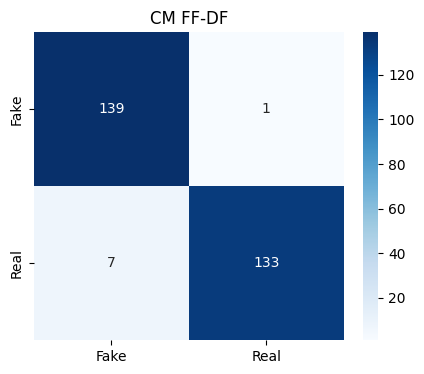

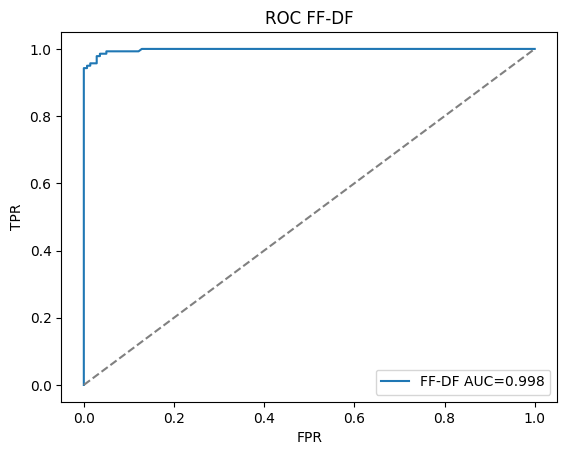


🔍 Testing on FF-F2F


Seq→LSTM FF-F2F:   0%|          | 0/18 [00:00<?, ?it/s]

→ FF-F2F: AUC=0.9846, Acc=95.00%


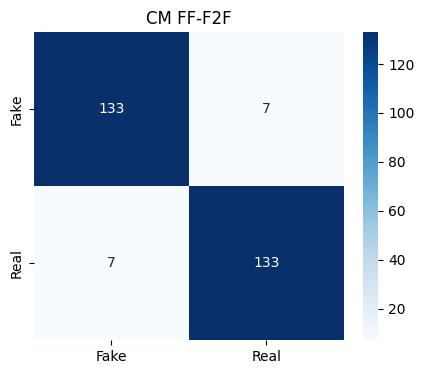

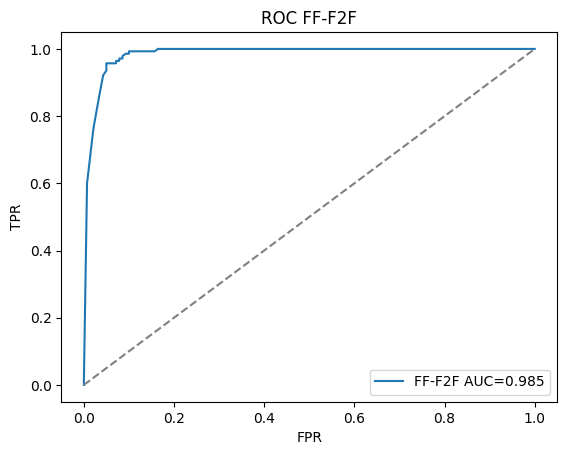


🔍 Testing on FF-FS


Seq→LSTM FF-FS:   0%|          | 0/18 [00:00<?, ?it/s]

→ FF-FS: AUC=0.9930, Acc=96.07%


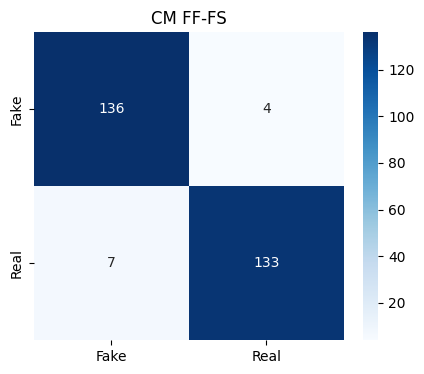

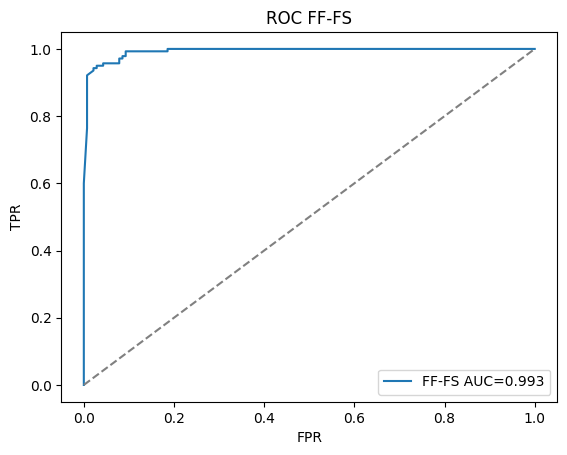


🔍 Testing on FF-NT


Seq→LSTM FF-NT:   0%|          | 0/18 [00:00<?, ?it/s]

→ FF-NT: AUC=0.9633, Acc=92.50%


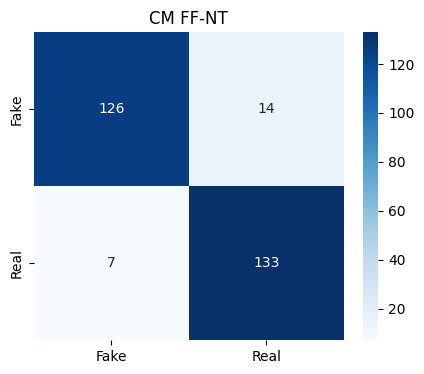

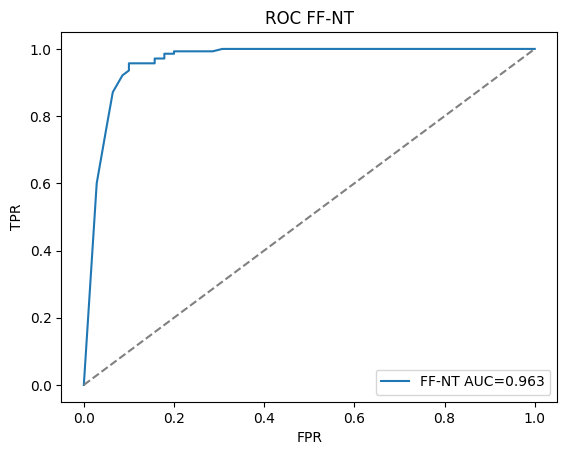


🔔 Overall FF++: AUC=0.9847, Acc=95.18%


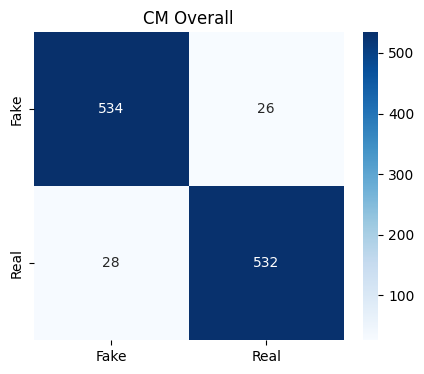

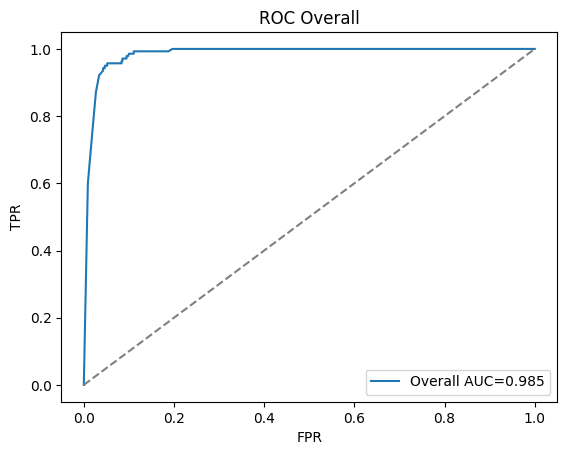

✅ Saved per‑category and overall ROC curves to roc_curves.json

📊 Summary Results:
FF-DF: AUC=0.9977, Acc=97.14%
FF-F2F: AUC=0.9846, Acc=95.00%
FF-FS: AUC=0.9930, Acc=96.07%
FF-NT: AUC=0.9633, Acc=92.50%
Overall: AUC=0.9847, Acc=95.18%


In [6]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from PIL import Image
from tqdm.auto import tqdm
import json

# … assume FFppFramePredictionsDataset, LSTMClassifier, base_model, lstm_model, device, transform are defined above …

roc_curves = {}
results    = {}

# to accumulate overall
all_probs_overall = []
all_labels_overall = []

# testing loop
categories = ["FF-DF","FF-F2F","FF-FS","FF-NT"]
for cat in categories:
    print(f"\n🔍 Testing on {cat}")
    real_ds = FFppFramePredictionsDataset(
        json_path="/kaggle/input/ff-dd-split/FaceForensics_datasplit.json",
        root_dir="/kaggle/input/ff-dataset",
        split="test",
        category="FF-real",
        base_model=base_model,
        transform=transform
    )
    fake_ds = FFppFramePredictionsDataset(
        json_path="/kaggle/input/ff-dd-split/FaceForensics_datasplit.json",
        root_dir="/kaggle/input/ff-dataset",
        split="test",
        category=cat,
        base_model=base_model,
        transform=transform
    )

    loader = DataLoader(real_ds + fake_ds,
                        batch_size=16, shuffle=False, num_workers=0)

    all_p, all_l = [], []
    with torch.no_grad():
        for seqs, labs in tqdm(loader, total=len(loader), desc=f"Seq→LSTM {cat}"):
            seqs, labs = seqs.to(device), labs.to(device)
            logits = lstm_model(seqs)
            probs  = torch.sigmoid(logits).cpu().numpy()
            all_p.extend(probs.tolist())
            all_l.extend(labs.cpu().numpy().tolist())

    # extend overall lists
    all_probs_overall.extend(all_p)
    all_labels_overall.extend(all_l)

    # per‐category metrics
    auc  = roc_auc_score(all_l, all_p)
    acc  = (np.array(all_p) > 0.5).astype(int).tolist()
    acc  = np.mean(np.array(acc) == np.array(all_l)) * 100
    results[cat] = {"AUC": auc, "Accuracy": acc}
    print(f"→ {cat}: AUC={auc:.4f}, Acc={acc:.2f}%")

    # confusion matrix
    cm = confusion_matrix(all_l, (np.array(all_p)>0.5).astype(int))
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Fake","Real"], yticklabels=["Fake","Real"])
    plt.title(f"CM {cat}"); plt.show()

    # ROC curve & save values
    fpr, tpr, _ = roc_curve(all_l, all_p)
    roc_curves[cat] = {"fpr": fpr.tolist(),
                       "tpr": tpr.tolist(),
                       "auc": float(auc)}

    plt.plot(fpr, tpr, label=f"{cat} AUC={auc:.3f}")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.title(f"ROC {cat}"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

# --- now compute overall metrics & curve ---
overall_auc = roc_auc_score(all_labels_overall, all_probs_overall)
overall_acc = (np.array(all_probs_overall)>0.5).astype(int).tolist()
overall_acc = np.mean(np.array(overall_acc)==np.array(all_labels_overall)) * 100
results["Overall"] = {"AUC": overall_auc, "Accuracy": overall_acc}
print(f"\n🔔 Overall FF++: AUC={overall_auc:.4f}, Acc={overall_acc:.2f}%")

# overall confusion matrix
cm = confusion_matrix(all_labels_overall, (np.array(all_probs_overall)>0.5).astype(int))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Fake","Real"], yticklabels=["Fake","Real"])
plt.title("CM Overall"); plt.show()

# overall ROC
fpr_o, tpr_o, _ = roc_curve(all_labels_overall, all_probs_overall)
roc_curves["Overall"] = {"fpr": fpr_o.tolist(),
                         "tpr": tpr_o.tolist(),
                         "auc": float(overall_auc)}

plt.plot(fpr_o, tpr_o, label=f"Overall AUC={overall_auc:.3f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Overall"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

# --- save all curves to JSON ---
with open("roc_curves.json", "w") as fp:
    json.dump(roc_curves, fp, indent=2)
print("✅ Saved per‑category and overall ROC curves to roc_curves.json")

# --- print summary table ---
print("\n📊 Summary Results:")
for name, m in results.items():
    print(f"{name}: AUC={m['AUC']:.4f}, Acc={m['Accuracy']:.2f}%")


In [7]:
# import torch.multiprocessing as mp

# # ⚡️ Force the 'spawn' start method so CUDA can initialize safely in workers
# mp.set_start_method('spawn', force=True)


# from tqdm.auto import tqdm

# # create train datasets (real + each fake)
# categories = ["FF-DF","FF-F2F","FF-FS","FF-NT"]
# train_seqs, train_labels = [], []

# for cat in ["FF-real"] + categories:
#     print(f"\n⏳ Processing category: {cat}")
#     ds = FFppFramePredictionsDataset(
#         json_path="/kaggle/input/ff-dd-split/FaceForensics_datasplit.json",
#         root_dir="/kaggle/input/ff-dataset",
#         split="train",
#         category=cat,
#         base_model=base_model,
#         transform=transform
#     )
#     loader = DataLoader(ds, batch_size=32, shuffle=True, num_workers=0)

#     # wrap the loader in tqdm so you see per‑batch progress
#     for seqs, labs in tqdm(loader,
#                            desc=f"Building sequences for {cat}",
#                            total=len(loader)):
#         train_seqs.append(seqs)
#         train_labels.append(labs)

# # once all batches are done you'll see the bar reach 100%
# train_seqs = torch.cat(train_seqs, dim=0)
# train_labels = torch.cat(train_labels, dim=0)


In [8]:
# # ---------------------------
# # 4) Train LSTM
# # ---------------------------
# lstm_model = LSTMClassifier().to(device)
# optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
# criterion = nn.BCEWithLogitsLoss()

# batch_size = 32
# num_epochs = 10
# dataset = torch.utils.data.TensorDataset(train_seqs, train_labels)
# loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# for epoch in range(num_epochs):
#     lstm_model.train()
#     epoch_loss = 0
#     correct = 0
#     total = 0
#     for seqs, labs in loader:
#         seqs, labs = seqs.to(device), labs.to(device)
#         logits = lstm_model(seqs)
#         loss = criterion(logits, labs)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()*seqs.size(0)
#         preds = (torch.sigmoid(logits) > 0.5).float()
#         correct += (preds == labs).sum().item()
#         total += seqs.size(0)

#     print(f"Epoch {epoch+1}/{num_epochs} "
#           f"Loss: {epoch_loss/total:.4f} "
#           f"Acc: {100*correct/total:.2f}%")

In [9]:
# # after training completes:

# save_path = "lstm_best.pth"
# torch.save({
#     "epoch": num_epochs,
#     "model_state_dict": lstm_model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
#     "loss": epoch_loss/total,            # final epoch loss
# }, save_path)

# print(f"✅ Saved LSTM checkpoint to {save_path}")


In [10]:
# # ---------------------------
# # 5) At test time
# # ---------------------------
# test_ds = FFppFramePredictionsDataset(
#     json_path="/kaggle/input/ff-dd-split/FaceForensics_datasplit.json",
#     root_dir="/kaggle/input/ff-dataset",
#     split="test",
#     category="FF-real",  # or loop through real+fakes as above
#     base_model=base_model,
#     transform=transform
# )
# test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
# lstm_model.eval()
# all_preds, all_labels = [], []
# with torch.no_grad():
#     for seq, lab in test_loader:
#         seq, lab = seq.to(device), lab.to(device)
#         logit = lstm_model(seq)
#         prob = torch.sigmoid(logit).item()
#         all_preds.append(prob)
#         all_labels.append(lab.item())

# # compute your final AUC / accuracy on all_preds vs all_labels


In [11]:
# import os
# import torch
# import numpy as np
# import torch.nn as nn
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
# from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
# from PIL import Image
# from tqdm.auto import tqdm
# import json

# lstm_model.eval()

# transform = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
# ])

# # ---------------------------
# # 4) Testing Loop per Category
# # ---------------------------
# categories = ["FF-DF","FF-F2F","FF-FS","FF-NT"]
# results = {}

# for cat in categories:
#     print(f"\n🔍 Testing with LSTM on category: {cat}")

#     # real vs fake datasets
#     real_ds = FFppFrameSeqDataset(
#         json_path="/kaggle/input/ff-dd-split/FaceForensics_datasplit.json",
#         root_dir="/kaggle/input/ff-dataset",
#         split="test",
#         category="FF-real",
#         base_model=base_model,
#         transform=transform
#     )
#     fake_ds = FFppFrameSeqDataset(
#         json_path="/kaggle/input/ff-dd-split/FaceForensics_datasplit.json",
#         root_dir="/kaggle/input/ff-dataset",
#         split="test",
#         category=cat,
#         base_model=base_model,
#         transform=transform
#     )

#     loader = DataLoader(real_ds + fake_ds, batch_size=16, shuffle=False, num_workers=0)

#     all_probs, all_labels = [], []
#     with torch.no_grad():
#         for seqs, labs in tqdm(loader, desc=f"Seq → LSTM ({cat})", total=len(loader)):
#             seqs, labs = seqs.to(device), labs.to(device)
#             logits = lstm_model(seqs)
#             probs = torch.sigmoid(logits).cpu().numpy()
#             all_probs.extend(probs.tolist())
#             all_labels.extend(labs.cpu().numpy().tolist())

#     # metrics
#     auc = roc_auc_score(all_labels, all_probs)
#     bin_pred = [1 if p>0.5 else 0 for p in all_probs]
#     acc = np.mean(np.array(bin_pred)==np.array(all_labels))
#     results[cat] = {"AUC": auc, "Accuracy": acc*100}

#     print(f"▶️  {cat} → AUC: {auc:.4f}, Acc: {acc*100:.2f}%")

#     # confusion matrix
#     cm = confusion_matrix(all_labels, bin_pred)
#     plt.figure(figsize=(5,4))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#                 xticklabels=["Fake","Real"], yticklabels=["Fake","Real"])
#     plt.title(f"Confusion ({cat})"); plt.show()

#     # ROC curve
#     fpr, tpr, _ = roc_curve(all_labels, all_probs)
#     plt.figure()
#     plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
#     plt.plot([0,1],[0,1],"--", color="gray")
#     plt.title(f"ROC Curve ({cat})")
#     plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

# # ---------------------------
# # 5) Summary
# # ---------------------------
# print("\n📊 Summary Results:")
# for cat, m in results.items():
#     print(f"{cat}: AUC={m['AUC']:.4f}, Accuracy={m['Accuracy']:.2f}%")


In [12]:
# import os
# import torch
# import numpy as np
# import torch.nn as nn
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
# from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve
# from PIL import Image
# from tqdm import tqdm
# import json

# # ---------------------------
# # Custom Dataset Class (Frame-Based)
# # ---------------------------
# class FaceForensicsFrameDataset(Dataset):
#     def __init__(self, json_path, root_dir, split, transform=None):
#         """
#         Dataset for testing that loads frames individually instead of grouping by video.
#         """
#         with open(json_path, 'r') as f:
#             self.data = json.load(f)

#         self.root_dir = root_dir
#         self.transform = transform
#         self.samples = []  # Store individual frames and labels

#         for category, category_data in self.data.get("FaceForensics++", {}).items():
#             try:
#                 videos = category_data[split]["c23"]
#             except KeyError:
#                 print(f"⚠️ Category {category} does not have the split '{split}' or key 'c23'.")
#                 continue

#             for video_id, info in videos.items():
#                 label = 1 if category == "FF-real" else 0
#                 for frame_path in info.get("frames", []):
#                     frame_path = frame_path.replace("\\", "/")  # Normalize Windows paths
#                     if frame_path.startswith("FaceForensics++/"):
#                         frame_path = "/".join(frame_path.split("/")[1:])
#                     full_path = os.path.join(self.root_dir, frame_path)
                    
#                     if os.path.isfile(full_path):
#                         self.samples.append((full_path, label))
#                     else:
#                         print(f"⚠️ Skipping missing or invalid file: {full_path}")

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         frame_path, label = self.samples[idx]
#         try:
#             image = Image.open(frame_path).convert("RGB")
#             if self.transform:
#                 image = self.transform(image)
#             return image, torch.tensor(label, dtype=torch.float)
#         except Exception as e:
#             print(f"❌ ERROR loading {frame_path}: {e}")
#             return torch.zeros((3, 224, 224)), torch.tensor(label, dtype=torch.float)  # Dummy tensor

# # ---------------------------
# # Load Model
# # ---------------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load model architecture (Ensure eatformer_base is correctly defined)
# model = eatformer_base(pretrained=False)
# model.head = nn.Linear(model.head.in_features, 1)  # Adjust classifier layer

# # Handle multiple GPUs
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)

# # Load weights safely
# checkpoint = torch.load("/kaggle/input/eatmodel3/best_checkpoint3.pth", map_location=device)
# model.load_state_dict(checkpoint["model_state_dict"])
# model.to(device)
# model.eval()

# # ---------------------------
# # Transformations & Dataloader
# # ---------------------------
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])

# test_dataset = FaceForensicsFrameDataset(
#     json_path="/kaggle/input/ff-dd-split/FaceForensics_datasplit.json",
#     root_dir="/kaggle/input/ff-dataset",
#     split="test",
#     transform=transform
# )

# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# # ---------------------------
# # Model Inference Per Frame
# # ---------------------------
# predictions, labels = [], []

# with torch.no_grad():
#     for frame, label in tqdm(test_loader, desc="Processing Frames"):
#         frame = frame.to(device)
#         label = label.to(device)
        
#         if frame.dim() == 3:  # If (C, H, W), add batch dim
#             frame = frame.unsqueeze(0)
#         output = model(frame)

#         prob = torch.sigmoid(output).item()
        
#         predictions.append(prob)
#         labels.append(label.item())

# # ---------------------------
# # Compute AUC Per Frame
# # ---------------------------
# if predictions:
#     auc = roc_auc_score(labels, predictions)
#     f1 = f1_score(labels, [1 if p > 0.5 else 0 for p in predictions])
#     print(f"AUC: {auc:.4f}, F1: {f1:.4f}")
# else:
#     print("⚠️ No predictions were made! Check your dataset paths and model.")

# # ---------------------------
# # Confusion Matrix
# # ---------------------------
# binary_predictions = [1 if p > 0.5 else 0 for p in predictions]
# cm = confusion_matrix(labels, binary_predictions)

# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
# plt.show()

# # ---------------------------
# # ROC Curve
# # ---------------------------
# fpr, tpr, _ = roc_curve(labels, predictions)

# plt.figure()
# plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {auc:.4f}")
# plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic (ROC) Curve")
# plt.legend(loc="lower right")
# plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
# plt.show()
